[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/063_transformer_encoder/transformer_encoder.ipynb)

# *Transformer* Encoder

En posts anteriores hemos entrado en detalle en los mecanismos de atención utilizados en la arquitectura *Transformer*. En este post vamos a implementar nuestro primer *Transformer* completo, en este caso el conocido como *Transformer Encoder*. Esta arquitectura es utilizada en modelos como [BERT](https://arxiv.org/abs/1810.04805) o [ViT](https://arxiv.org/abs/2010.11929).

![](encoder.png)

Como puedes ver en la figura, un *Transformer* no es más que una secuencia de capas formada por:

- El mecanismo de atención *multi-head* que hemos visto en el post anterior
- Normalización y conexión residual (inspirado en ResNet)
- Un MLP
- Otra normalización y conexión residual

Además, a la entrada de la primera capa, tenemos una etapa de `embedding` para proyectar nuestros *inputs* a la dimensión adecuada a la cual añadimos un `postitional encoding`, el mecanismo que le dirá al transformer en qué posición de la secuencia se encuentra cada vector. Vamos a ver un ejemplo de implementación.

## Implementación

In [1]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [2]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X 
    self.y = y 

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [3]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 784]), torch.Size([64]))

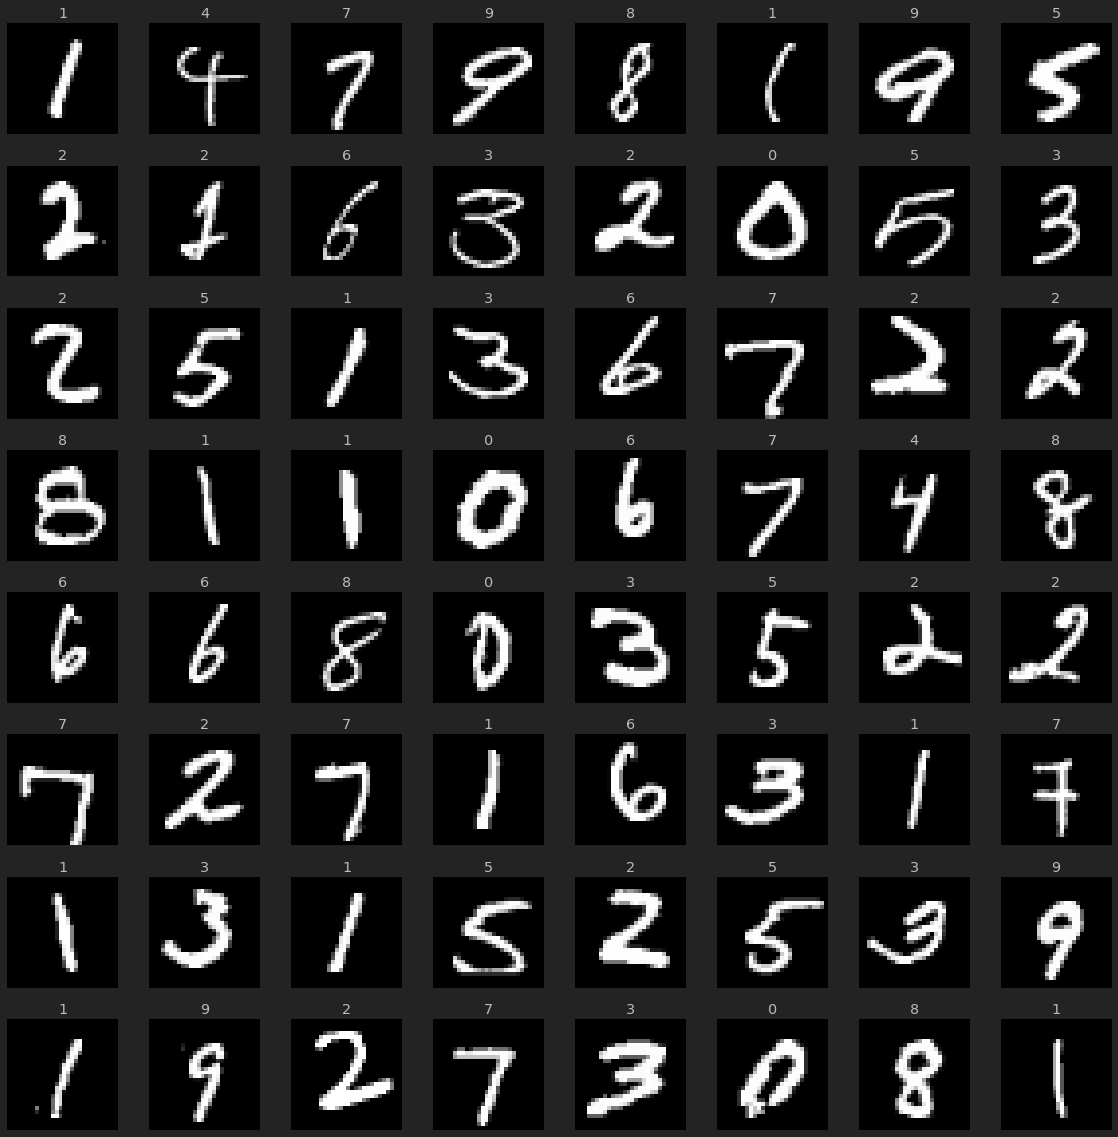

In [4]:
r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

In [5]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(784, 784),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(784, 10)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [6]:
mlp = MLP()
outuput = mlp(torch.randn(64, 784))
outuput.shape

torch.Size([64, 10])

In [7]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(mlp, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 623 K 
/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Obtenemos una precisión en los datos de validación del 97%, nada impresionante debido a la simplicidad del modelo.

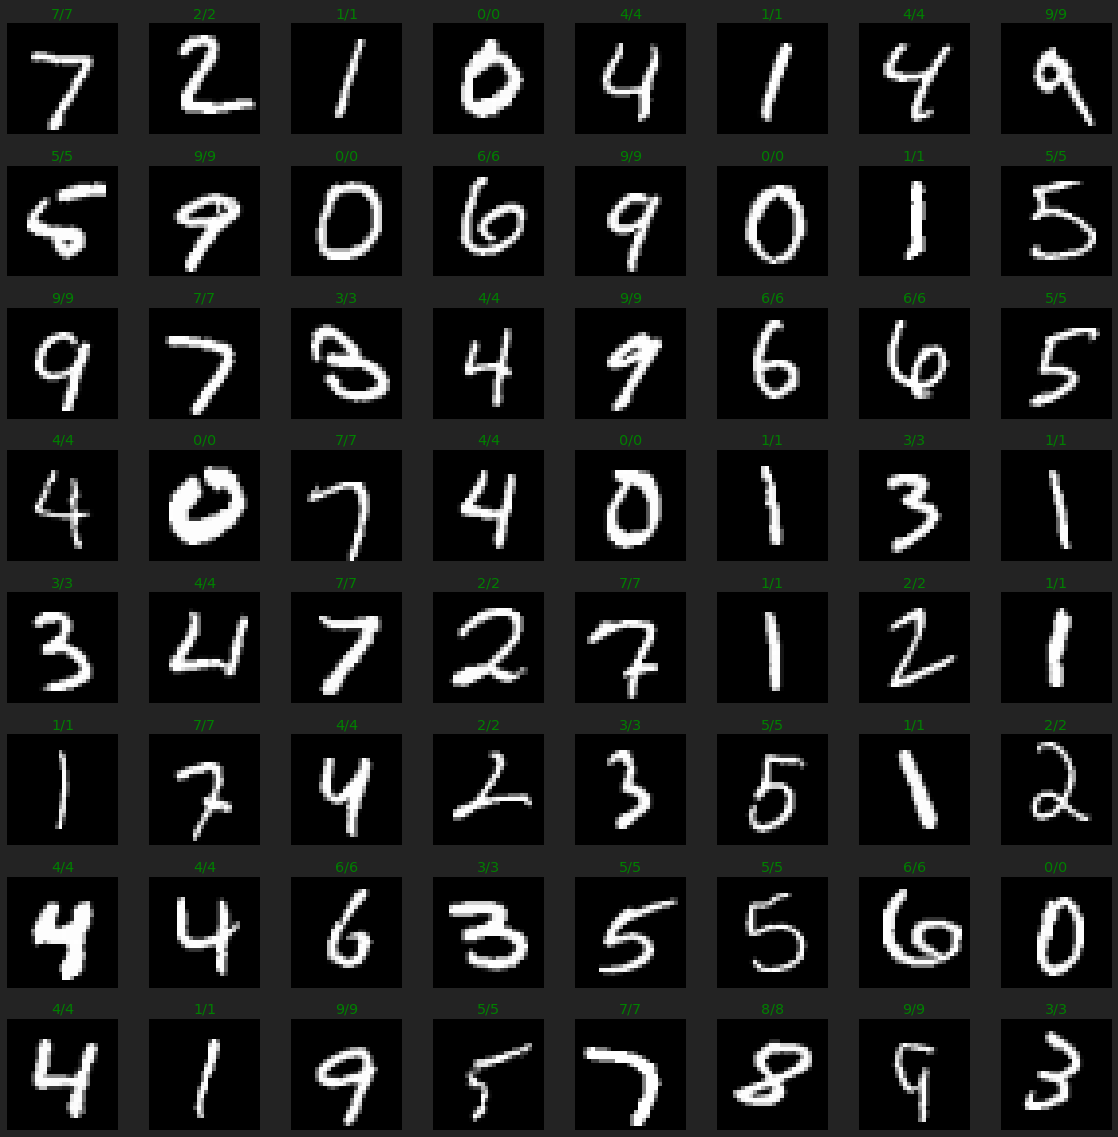

In [8]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Vamos ahora a resolver el mismo problema, utilizando un *Transformer*. Lo primero que tenemos que tener en cuenta es que los mecanismos de atención funcionan con secuencias, por lo que tenemos que reinterpretar nuestras imágenes. Para ello, vamos a dividirlas en 16 *patches* de 7x7. De esta manera, nuestras imágenes ahora serán secuencias de *patches* con las que nuestro mecanismo de atención podrá trabajar.

In [9]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X 
    self.y = y 
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(28, 28) # 28 x 28
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # 4 x 4 x 7 x 7
    patches = patches.contiguous().view(-1, h*w) # 16 x 49
    return patches, torch.tensor(self.y[ix]).long()

In [10]:
attn_dm = MNISTDataModule(Dataset = AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 16, 49]), torch.Size([64]))

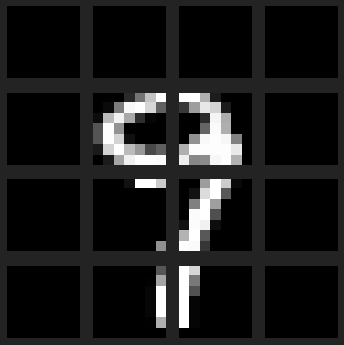

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(imgs[6,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads 
        
        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)
        
        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L) 
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)
    
class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd),
        )
        
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x
    
class Model(MLP):

    def __init__(self, n_input=7*7, n_embd=7*7, seq_len=4*4, n_heads=4*4, n_layers=1):
        super().__init__()
        self.mlp = None
        self.pos_emb = torch.nn.Parameter(torch.zeros(1, seq_len, n_embd))
        self.inp_emb = torch.nn.Linear(n_input, n_embd)
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)])
        self.fc = torch.nn.Linear(n_embd*seq_len, 10)

    def forward(self, x):
        # embedding
        e = self.inp_emb(x) + self.pos_emb
        # transformer blocks
        x = self.tranformer(x)
        # classifier
        y = self.fc(x.view(x.size(0), -1))
        return y

In [13]:
model = Model(n_layers=3)
trainer = pl.Trainer(max_epochs=5, gpus=1)
trainer.fit(model, attn_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | inp_emb    | Linear     | 2 K   
1 | tranformer | Sequential | 527 K 
2 | fc         | Linear     | 7 K   


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Nuestro *Transformer* es capaz de clasificar mejor las imágenes con un número similar (ligeramente inferior) de parámetros.

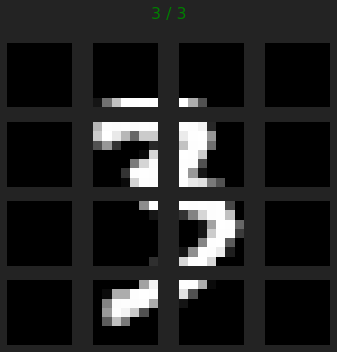

In [19]:
import random

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0,attn_dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(attn_imgs[ix,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{attn_labels[ix]} / {preds[ix].item()}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()

## Resumen

En este post hemos implementado nuestro primer *Transformer* 🎊 Para ello hemos usado el mecanismo de atención desarrollado en los posts anteriores y añadido el resto de piezas incluídas en el artículo original: Capas de normalización, conexiones residuales y un MLP. Además, hemos aprendido a proyectar nuestros *inputs* a la dimensión necesaria y permitirle al modelo a conocer la posición de cada vector en la secuencia. usando `embeddings`